In [1]:
import sys, os
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem, Descriptors
import sklearn
from sklearn.metrics import confusion_matrix, precision_score,recall_score 
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data_curation/train_set_all.csv')
df = df[df.columns.tolist()[1:]]
df[df.select_dtypes(np.float64).columns] = df.select_dtypes(np.float64).astype(np.float32)
df.head(2)

,y,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,MFP_2039,MFP_2040,MFP_2041,MFP_2042,MFP_2043,MFP_2044,MFP_2045,MFP_2046,MFP_2047,MFP_2048
0,1,9.843954,9.843954,0.299333,-0.498733,0.837506,259.348999,238.181000,259.157227,102,...,1,0,0,0,0,0,0,0,0,0
1,1,11.682268,11.682268,0.134704,-0.409691,0.474821,360.325012,333.109009,359.141876,130,...,0,0,0,0,0,0,0,0,0,0


In [3]:
columns = df.columns.to_numpy()
check_features = columns[df.isin([np.inf, -np.inf, np.NaN]).any(axis=0).to_numpy()].tolist()
check_features, len(check_features)

([], 0)

In [5]:
lowVar_features = df.std()[df.std() < 0.25].index.tolist()
len(lowVar_features)

1994

In [6]:
#descriptors = [x[0] for x in Descriptors._descList]
Fingerprints = ['MFP_%d'%(i+1) for i in range(2048)]
descriptors = ['HeavyAtomMolWt','NHOHCount','NOCount','RingCount']
features = Fingerprints + descriptors
features = [x for x in features if x not in check_features+lowVar_features]
len(features)

120

In [7]:
df.y.value_counts()/len(df)

y
1    0.822195
0    0.177805
Name: count, dtype: float64

In [8]:
X_train = np.c_[df[features]]
y_train = np.c_[df['y']]

### 1. Try a Balanced RandomForestClassifier

In [9]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

#RF_model = BalancedRandomForestClassifier(n_estimators=400,oob_score=True, random_state=10)
RF_model = BalancedRandomForestClassifier(n_estimators=400,
                                          criterion='gini',
                                          oob_score=True, random_state=10)

RF_model.fit(X_train, y_train[:,0])
y_train_predict = RF_model.predict(X_train)
y_oob_predict = np.argmax(RF_model.oob_decision_function_, axis=1)

In [10]:
new = pd.read_csv('data_curation/test_set_all.csv')
X_test1 = np.c_[new[features]]
y_test1 = np.c_[new['y']]
y_test1_predict = RF_model.predict(X_test1)
len(new)

204

confusion matrix

In [11]:
confusion_matrix(y_train, y_oob_predict)

array([[ 256,   34],
       [ 185, 1156]])

In [12]:
confusion_matrix(y_test1, y_test1_predict)

array([[60, 37],
       [27, 80]])

precision (for BBBP prediction, TP/(TP+FP) is more important)

In [13]:
precision_score(y_train, y_oob_predict)

0.9714285714285714

In [14]:
precision_score(y_test1, y_test1_predict)

0.6837606837606838

recall (TP/(TP+FN)), also called sensitivity

In [15]:
recall_score(y_train, y_oob_predict)

0.8620432513049963

In [16]:
recall_score(y_test1, y_test1_predict)

0.7476635514018691

### ROC curve for oob prediction

In [17]:
y_probas = RF_model.oob_decision_function_
y_scores = y_probas[:, 1] 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores)

In [18]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

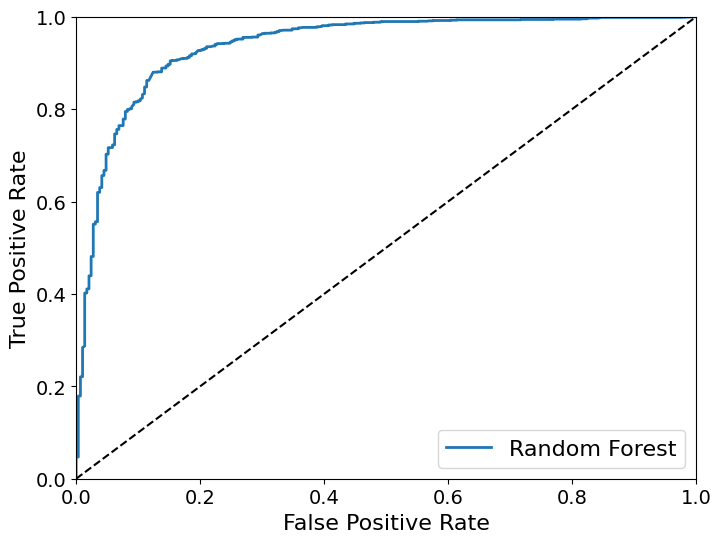

In [19]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [20]:
roc_auc_score(y_train, y_scores)

0.937514464244388

ROC curve for test set

In [21]:
y_probas1 = RF_model.predict_proba(X_test1)
y_scores1 = y_probas1[:, 1] 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test1, y_scores1)

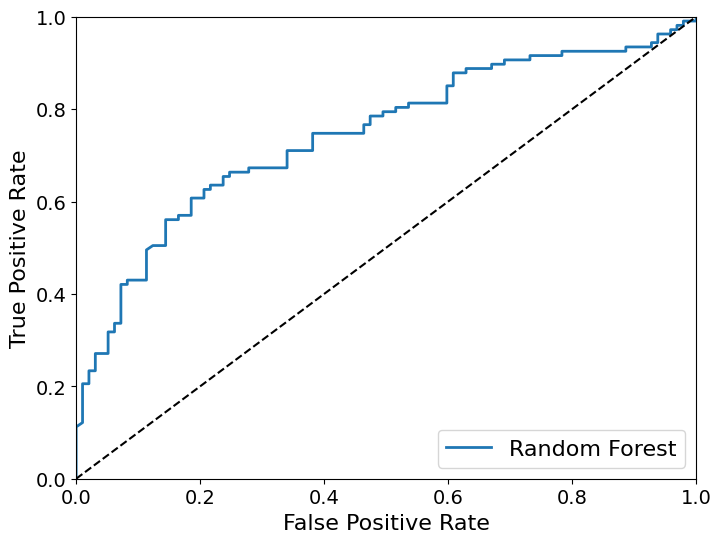

In [22]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [23]:
roc_auc_score(y_test1, y_scores1)

0.7444840543404952